### > Sample of partial least squares regression (PLSR) for a normal tabular dataset.
### > No. of latent components determined by cross validation and model accuracy estimated by double cross validation.
### > Final model is mean of PLS models obtained by double cross validation. Each model is trained by all data with hyper-parameters selected by each outer CV.
### > Functions for inference, partial residuals plots, regression coefficients, VIP and latent structure plot are prepared.

In [1]:
# --------------------------------------------------
# Libraries
# --------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import fetch_california_housing

In [2]:
# --------------------------------------------------
# Dataset
# --------------------------------------------------
analysis_data = fetch_california_housing(as_frame = True).frame
analysis_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [3]:
# --------------------------------------------------
# Settings
# --------------------------------------------------
feature_names = analysis_data.columns[:-1].tolist()
target_name = analysis_data.columns[-1:].tolist()
n_outer_cross_varidation = 5
n_inner_cross_varidation = 5
n_max_latent_components = len(feature_names)
scoring = r2_score
score_direction = ['maximize', 'minimize'][0] # If scoring function is accuracy based, select 0 ("maximize"). If scoring function is error based, select 1 ("minimize").

Complete outer cross validation 1/5. Number of latent components: 7.
Complete outer cross validation 2/5. Number of latent components: 7.
Complete outer cross validation 3/5. Number of latent components: 8.
Complete outer cross validation 4/5. Number of latent components: 8.
Complete outer cross validation 5/5. Number of latent components: 7.
----------------------------------------------
Model accuracy: 0.6008
----------------------------------------------


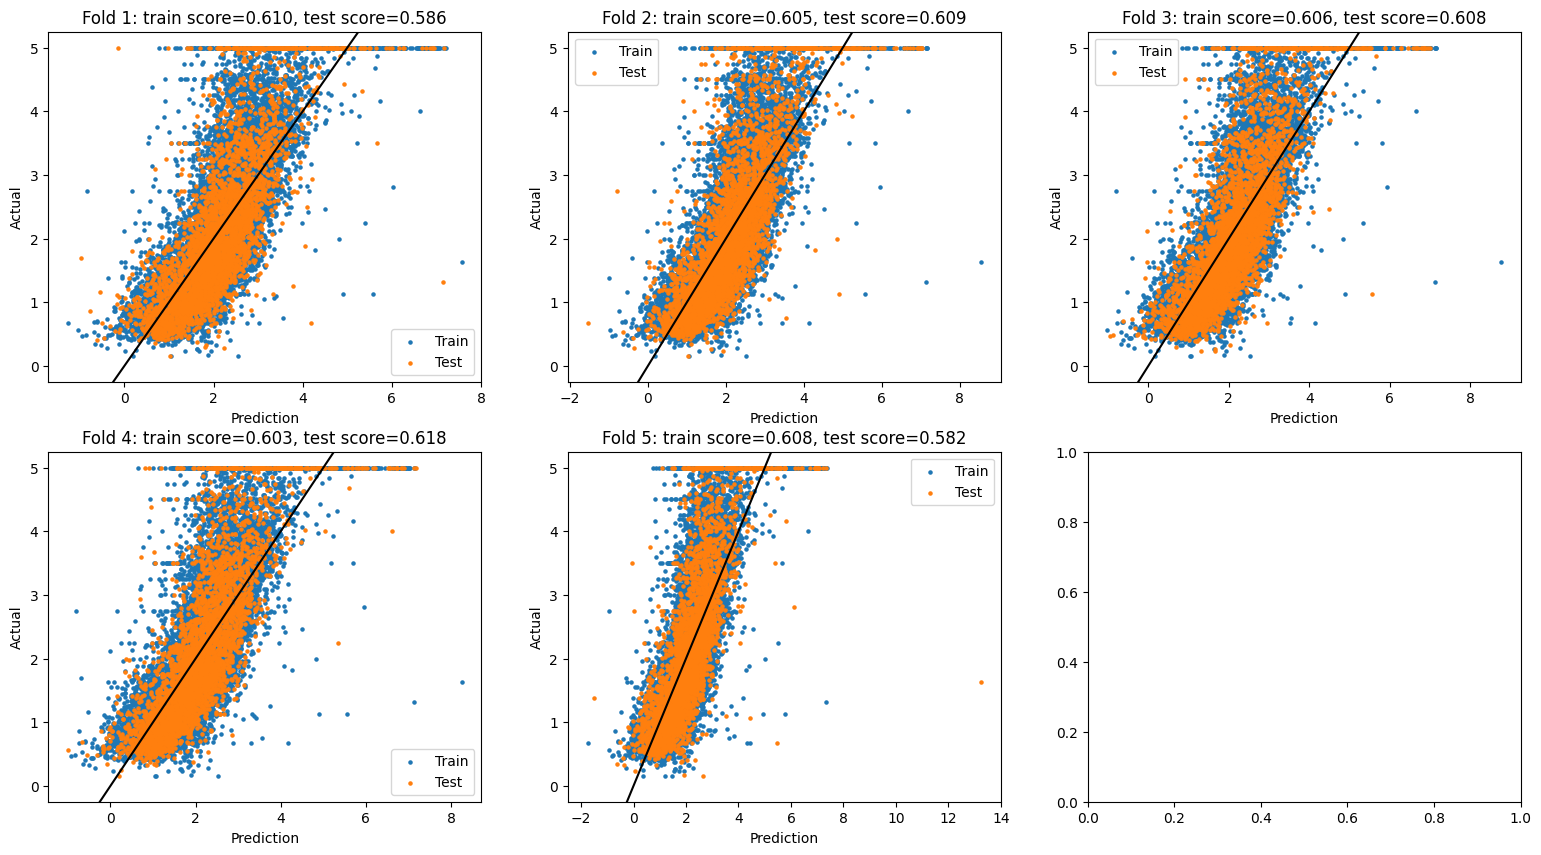

In [4]:
# --------------------------------------------------
# Model training by double cross validation
# --------------------------------------------------

test_score_list = []
latent_component_list = []

# ----- Outer cross validation
fig, ax = plt.subplots(math.ceil(n_outer_cross_varidation/3), 3, figsize = (19, 5*math.ceil(n_outer_cross_varidation/3)))
ax = ax.ravel()
outer_kfold = KFold(n_splits = n_outer_cross_varidation, shuffle = True)
for outer_fold, (modeling_index, test_index) in enumerate(outer_kfold.split(analysis_data)):
    # Split whole data to modeling data and test data
    modeling_data = analysis_data.iloc[modeling_index].copy()
    test_data = analysis_data.iloc[test_index].copy()

    # ----- Inner cross validation
    score_data = pd.DataFrame()
    inner_kfold = KFold(n_splits = n_inner_cross_varidation, shuffle = True)
    for inner_fold, (train_index, val_index) in enumerate(inner_kfold.split(modeling_data)):
        # Split modeling data to training data and validation data
        train_data = modeling_data.iloc[train_index].copy()
        val_data = modeling_data.iloc[val_index].copy()
        # Scaling (training data)
        X = train_data[feature_names].values
        y = train_data[target_name].values
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        scaled_X = scaler_X.fit_transform(X)
        scaled_y = scaler_y.fit_transform(y)
        # Scaling (validation data)
        val_scaled_X = scaler_X.transform(val_data[feature_names].values)
        val_scaled_y = scaler_y.transform(val_data[target_name].values)
        # Serch no. of latent components
        for n_latent_component in range(1, n_max_latent_components+1):
            # Fitting
            model = PLSRegression(n_components = n_latent_component)
            model.fit(scaled_X, scaled_y)
            # Validation score
            score = scoring(val_scaled_y, model.predict(val_scaled_X))
            # Score saving
            score_data = pd.concat([score_data,
                                    pd.DataFrame([[outer_fold, inner_fold, n_latent_component, score]],
                                                 columns = ['Outer_fold', 'Inner_fold', 'N_latent_components', 'Score'])])

    # ----- Training by best latent components
    # Best latent components
    score_summary_data = score_data[['N_latent_components', 'Score']].groupby('N_latent_components').mean().reset_index()
    score_summary_data.sort_values('Score', ascending = score_direction == 'minimize', inplace = True)
    best_n_components = score_summary_data['N_latent_components'].values[0]
    # Scaling (modeling data)
    X = modeling_data[feature_names].values
    y = modeling_data[target_name].values
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    scaled_X = scaler_X.fit_transform(X)
    scaled_y = scaler_y.fit_transform(y)
    # Scaling (test data)
    test_scaled_X = scaler_X.transform(test_data[feature_names].values)
    test_scaled_y = scaler_y.transform(test_data[target_name].values)
    # Fitting
    model = PLSRegression(n_components = best_n_components)
    model.fit(scaled_X, scaled_y)

    # ----- Model evaluation
    # Prediction
    train_pred_values =  scaler_y.inverse_transform(model.predict(scaled_X))
    test_pred_values = scaler_y.inverse_transform(model.predict(test_scaled_X))
    # Score
    train_score = scoring(y, train_pred_values)
    test_score = scoring(test_data[target_name].values, test_pred_values)
    # Plot
    ax[outer_fold].scatter(train_pred_values, y, label = 'Train', s = 5)
    ax[outer_fold].scatter(test_pred_values, test_data[target_name].values, label = 'Test', s = 5)
    ax[outer_fold].axline((0, 0), slope = 1, color = 'k')
    ax[outer_fold].legend()
    ax[outer_fold].set_xlabel('Prediction')
    ax[outer_fold].set_ylabel('Actual')
    ax[outer_fold].set_title(f'Fold {outer_fold+1}: train score={train_score:.3f}, test score={test_score:.3f}')

    # ----- Model output
    test_score_list.append(test_score)
    latent_component_list.append(best_n_components)

    # ----- Log
    print(f"Complete outer cross validation {outer_fold+1}/{n_outer_cross_varidation}. Number of latent components: {best_n_components}.")

# ----- Print
print('----------------------------------------------')
print(f"Model accuracy: {np.mean(test_score_list):.4f}")
print('----------------------------------------------')
plt.show()

In [5]:
# --------------------------------------------------
# Train final models by all data
# --------------------------------------------------

# Data array
X = analysis_data[feature_names].values
y = analysis_data[target_name].values

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
scaled_X = scaler_X.fit_transform(X)
scaled_y = scaler_y.fit_transform(y)

# Training
model_list = []
for n_comp in np.unique(latent_component_list):
    model = PLSRegression(n_components = n_comp)
    model.fit(scaled_X, scaled_y)
    model_list.append(model)

In [6]:
# --------------------------------------------------
# Class of trained models
# --------------------------------------------------

# Define class of trained models
class TrainedPLSRModel():
    def __init__(self, model_list, scaler_X, scaler_y):
        self.model_list = model_list
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y

    def predict(self, X):
        pred_values = np.zeros((X.shape[0], 1))
        weight = 1/len(self.model_list)
        scaled_X = self.scaler_X.transform(X)
        for model in self.model_list:
            partial_pred_values = (self.scaler_y.inverse_transform(model.predict(scaled_X)))*weight
            pred_values += partial_pred_values
        return pred_values

    def partial_residuals_plot(self, X, y, feature_names):
        # Caluculate pertial residuals
        fig, ax = plt.subplots(math.ceil(len(feature_names)/4), 4, figsize = (20, math.ceil(len(feature_names)/4)*4))
        ax = ax.ravel()
        full_residuals = y - self.predict(X)
        weight = 1/len(self.model_list)
        for i, feature in enumerate(feature_names):
            pred_values = np.zeros((X.shape[0], 1))
            for model in self.model_list:
                scaled_X = self.scaler_X.transform(X)
                scaled_X[:,[k for k in range(len(feature_names)) if k != i]] = 0
                partial_pred_values = (self.scaler_y.inverse_transform(model.predict(scaled_X)))*weight
                pred_values += partial_pred_values
            partial_residuals = pred_values + full_residuals
            # Plot
            ax[i].scatter(X[:,i], partial_residuals, s = 5)
            ax[i].plot([(X[:,i])[np.argmin(X[:,i])], (X[:,i])[np.argmax(X[:,i])]], [pred_values[np.argmin(X[:,i])], pred_values[np.argmax(X[:,i])]], color = 'k')
            ax[i].set_xlabel(feature)
            ax[i].set_ylabel('Partial residuals')
            ax[i].axhline(y.mean(), color = 'orange', label = 'Target mean')
            ax[i].legend()
        plt.show()

    def st_regression_coefficient(self, feature_names):
        # Weighted mean of regression coefficients of each PLSR model
        regression_coef = np.zeros((self.scaler_X.mean_.shape[0], 1))
        weight = 1/len(self.model_list)
        for model in self.model_list:
            coef = (model.x_rotations_@model.y_loadings_.T)*weight
            regression_coef += coef
        regression_coef_data = pd.DataFrame(regression_coef, columns = ["Standardized_regression_coefficient"])
        regression_coef_data['Feature_name'] = feature_names
        regression_coef_data = regression_coef_data[['Feature_name', 'Standardized_regression_coefficient']].copy()
        return regression_coef_data.iloc[regression_coef_data['Standardized_regression_coefficient'].abs().argsort()[::-1]]

    def _calculate_vip(self, model):
        t = model.x_scores_
        w = model.x_weights_
        q = model.y_loadings_
        p, h = w.shape
        vip = np.zeros((p,))
        s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
        total_s = np.sum(s)
        for i in range(p):
            weight = np.array([(w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h)])
            vip[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
        return vip

    def variable_importance_in_projection(self, feature_names):
        # Weighted mean of VIP values of PLSR each model
        weighted_vip = np.zeros((self.scaler_X.mean_.shape[0],))
        weight = 1/len(self.model_list)
        for model in self.model_list:
            vip_values = self._calculate_vip(model)*weight
            weighted_vip += vip_values
        vip_data = pd.DataFrame(weighted_vip.reshape(-1, 1), columns = ["VIP"])
        vip_data['Feature_name'] = feature_names
        vip_data.sort_values('VIP', inplace = True, ascending = False)
        return vip_data[['Feature_name', 'VIP']]

    def latent_component_structure_plot(self, feature_names, model_no):
        '''
        model_no: Select model number of PLS models contained in "self.model_list".
                  Latent structures of the selected model are returned.
                  Value range is 0 to len(self.model_list)-1.
        '''
        # Extract target model instance
        try:
            model = self.model_list[model_no]
        except IndexError:
            raise IndexError(f"Index out of range. Range of 'model_no' is 0 to {len(self.model_list)-1}.")
        # Plot
        fig, ax = plt.subplots(math.ceil(model.x_rotations_.shape[1]/4), 4, figsize = (27, 6*math.ceil(model.x_rotations_.shape[1]/4)))
        ax = ax.ravel()
        for i in range(model.x_rotations_.shape[1]):
            ax[i].barh(np.array(feature_names)[model.x_rotations_[:,i].argsort()], (model.x_rotations_[:,i])[model.x_rotations_[:,i].argsort()])
            ax[i].axvline(0, color = 'k')
            ax[i].set_title(f'Latent component {i+1}: Loading={model.y_loadings_.ravel()[i]:.3f}')
        plt.show()

# Instantiation
trained_model = TrainedPLSRModel(
    model_list = model_list,
    scaler_X = scaler_X,
    scaler_y = scaler_y
)

In [8]:
# --------------------------------------------------
# Inference
# --------------------------------------------------

# Inference
new_data = fetch_california_housing(as_frame = True).frame
new_data['Predicted_value'] = trained_model.predict(new_data[feature_names].values)
new_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,Predicted_value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,4.131690
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,3.976526
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,3.676679
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,3.241700
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,2.413673
...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,0.133613
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,0.553472
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,0.171155
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,0.319010


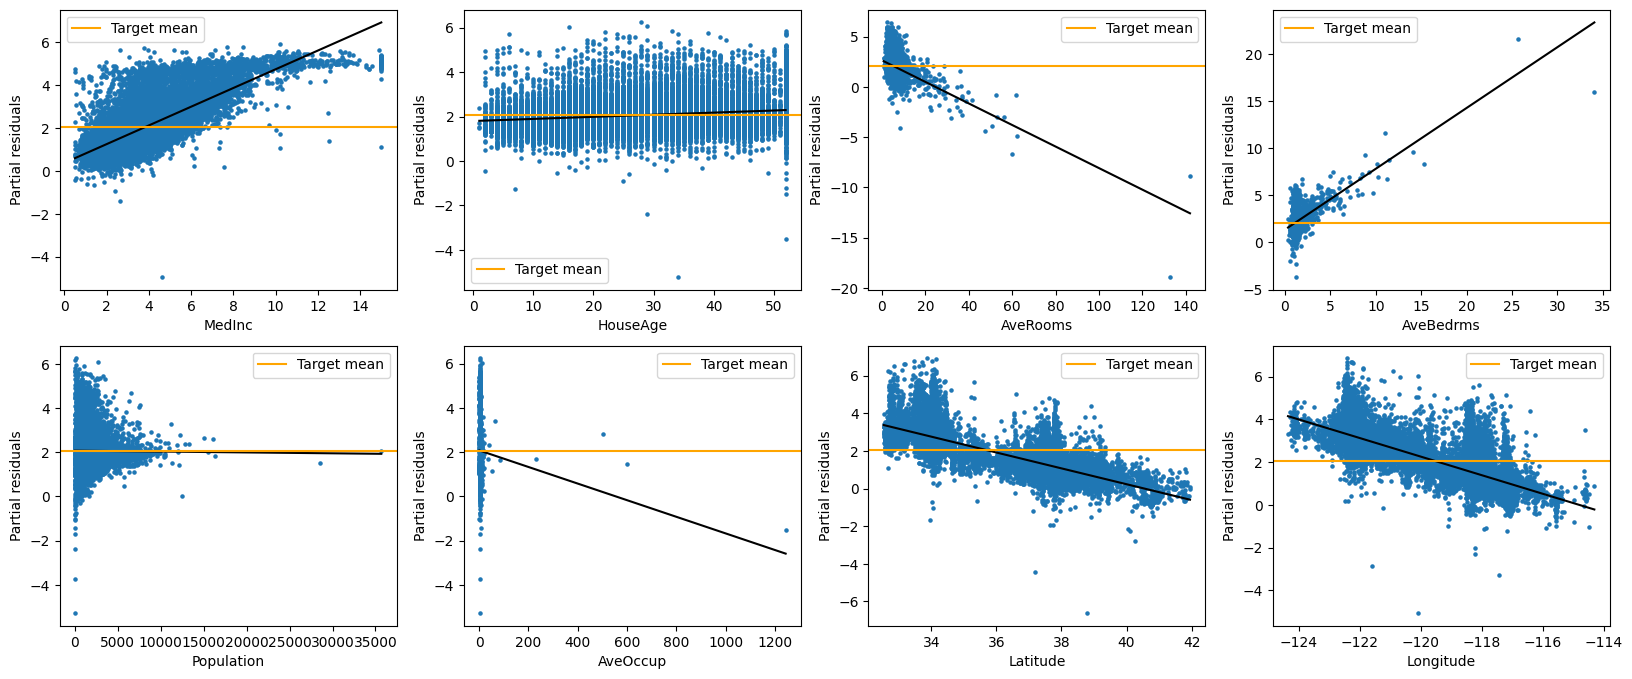

In [9]:
# --------------------------------------------------
# Partial residuls plot
# --------------------------------------------------

# Show plot
trained_model.partial_residuals_plot(analysis_data[feature_names].values, analysis_data[target_name].values, feature_names)

In [10]:
# --------------------------------------------------
# Standardized regression coefficient
# --------------------------------------------------

# Output dataframe
st_regression_coef_data = trained_model.st_regression_coefficient(feature_names)
st_regression_coef_data

,Feature_name,Standardized_regression_coefficient
6,Latitude,-0.779841
7,Longitude,-0.754402
0,MedInc,0.718957
3,AveBedrms,0.264943
2,AveRooms,-0.230111
1,HouseAge,0.102973
5,AveOccup,-0.033808
4,Population,-0.003899


In [11]:
# --------------------------------------------------
# Variable importance in projection
# --------------------------------------------------

# Output dataframe
VIP_data = trained_model.variable_importance_in_projection(feature_names)
VIP_data

,Feature_name,VIP
0,MedInc,2.409044
2,AveRooms,0.731706
6,Latitude,0.681764
1,HouseAge,0.643715
3,AveBedrms,0.587076
7,Longitude,0.492781
4,Population,0.415554
5,AveOccup,0.147532


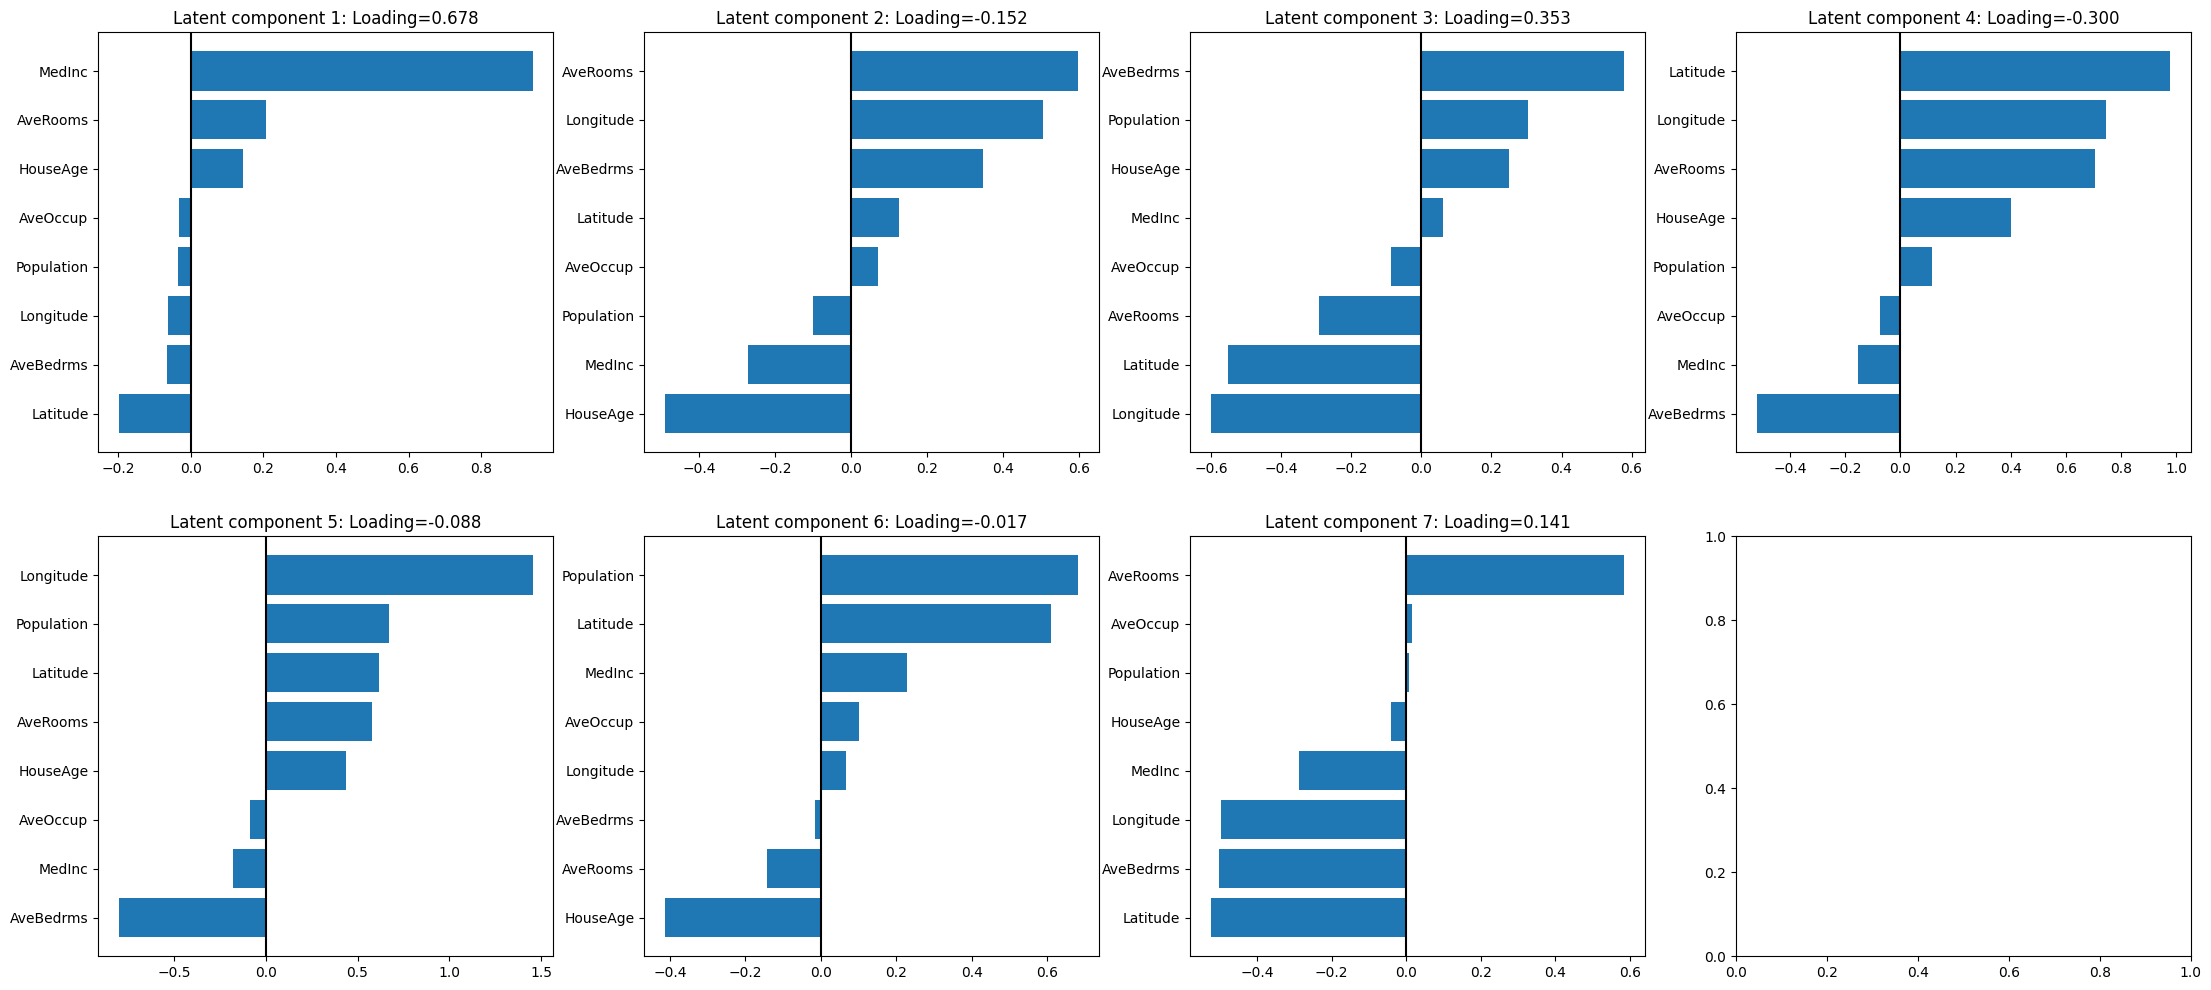

In [12]:
# --------------------------------------------------
# Plot of latent structure
# -------------------------------------------------

# Show plot
model_num = 0
trained_model.latent_component_structure_plot(feature_names, model_num)